In [ ]:
import os

# Проверяем подсоединён ли гугл диск
if os.path.exists("drive") and os.path.isdir("drive"):
    print("Google Диск подключён")
else:
    from google.colab import drive

    drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Проверяем папку с данными
if os.path.exists("neuron_data") and os.path.isdir("neuron_data"):
    print("Данные уже на локальном хранилище")
else:
    !mkdir neuron_data
    !unzip drive/MyDrive/neuron_data/toronto.zip -d neuron_data/tess
    !unzip drive/MyDrive/neuron_data/cremad.zip -d neuron_data/cremad
    !unzip drive/MyDrive/neuron_data/ravdess.zip -d neuron_data/ravdess
    !unzip drive/MyDrive/neuron_data/savee.zip -d neuron_data/savee

In [ ]:
# Импорт библиотек
# sklearn
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    classification_report,
    f1_score,
    recall_score,
    precision_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# tensorflow
import tensorflow as tf

# tf.keras
from tensorflow.keras.optimizers import SGD, Adam, Nadam, RMSprop, Adadelta, Adamax
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Прочие
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
import pickle

In [ ]:
# если выдаст ошибку с initialization of _internal failed without raising an exception
#!pip install numpy==1.23.5

In [ ]:
def extract_features(df_path, sam_rate, aud_dur, aud_ofs, n_mfccs):
    # функция для получения mfcc
    mfcc_arr = []
    input_length = sam_rate * aud_dur
    for path in df_path:
        l_data, _ = librosa.load(path, sr=sam_rate, offset=aud_ofs)
        if len(l_data) > input_length:
            # если загрузится больше чем n секунд, то делаем случайное смещение
            max_offset = len(l_data) - input_length
            offset = np.random.randint(max_offset)
            l_data = l_data[offset : (input_length + offset)]
        if input_length > len(l_data):
            # если аудио данных не хватает на нужную длительность
            # делаем случайное смещение и падинг (добавление нулями) к аудио данным
            max_offset = input_length - len(l_data)
            offset = np.random.randint(max_offset)
            l_data = np.pad(
                l_data,
                (offset, int(input_length) - len(l_data) - offset),
                "constant",
                constant_values=0,
            )
        # MFCC extraction
        MFCC = librosa.feature.mfcc(y=l_data, sr=sam_rate, n_mfcc=n_mfccs)
        mfcc_arr.append(MFCC)
    return mfcc_arr

In [ ]:
# датафреймы
tess_df = None
crema_df = None
ravdess_df = None
savee_df = None

# Количество mfcc для подсчёта на каждый фрэйм (промежуток времени)
num_mfcc = 75
# пересчитать/считать ли значения mfcc
calculate_mfcc = False
if calculate_mfcc == True:
    # если считаем/пересчитываем, то читаем csv с путями до аудиофайлов
    tess_df = pd.read_csv("drive/MyDrive/neuron_data/csv_tables/tess_path.csv")
    crema_df = pd.read_csv("drive/MyDrive/neuron_data/csv_tables/crema_path.csv")
    ravdess_df = pd.read_csv("drive/MyDrive/neuron_data/csv_tables/ravdess_path.csv")
    savee_df = pd.read_csv("drive/MyDrive/neuron_data/csv_tables/savee_path.csv")
    # параметры для получения mfcc
    sample_rate = 44100
    audio_dur = 2
    audio_offset = 0
    # добавляем mfcc в датафрейм
    tess_df["MFCC"] = extract_features(
        tess_df.Path, sample_rate, audio_dur, audio_offset, num_mfcc
    )
    ravdess_df["MFCC"] = extract_features(
        ravdess_df.Path, sample_rate, audio_dur, audio_offset, num_mfcc
    )
    savee_df["MFCC"] = extract_features(
        savee_df.Path, sample_rate, audio_dur, audio_offset, num_mfcc
    )
    crema_df["MFCC"] = extract_features(
        crema_df.Path, sample_rate, audio_dur, audio_offset, num_mfcc
    )
    # убираем столбец с путями
    tess_df = tess_df.drop("Path", axis=1)
    crema_df = crema_df.drop("Path", axis=1)
    ravdess_df = ravdess_df.drop("Path", axis=1)
    savee_df = savee_df.drop("Path", axis=1)
    # сохраняем датафрейм
    tess_df.to_pickle("drive/MyDrive/neuron_data/tables_with_mfcc/tess_path_mfcc.pkl")
    crema_df.to_pickle("drive/MyDrive/neuron_data/tables_with_mfcc/crema_path_mfcc.pkl")
    ravdess_df.to_pickle(
        "drive/MyDrive/neuron_data/tables_with_mfcc/ravdess_path_mfcc.pkl"
    )
    savee_df.to_pickle("drive/MyDrive/neuron_data/tables_with_mfcc/savee_path_mfcc.pkl")
else:
    # читаем уже посчитанные mfcc
    tess_df = pd.read_pickle(
        "drive/MyDrive/neuron_data/tables_with_mfcc/tess_path_mfcc.pkl"
    )
    crema_df = pd.read_pickle(
        "drive/MyDrive/neuron_data/tables_with_mfcc/crema_path_mfcc.pkl"
    )
    ravdess_df = pd.read_pickle(
        "drive/MyDrive/neuron_data/tables_with_mfcc/ravdess_path_mfcc.pkl"
    )
    savee_df = pd.read_pickle(
        "drive/MyDrive/neuron_data/tables_with_mfcc/savee_path_mfcc.pkl"
    )

In [ ]:
# переводим в список
tess_mfcc = tess_df["MFCC"].tolist()
ravdess_mfcc = ravdess_df["MFCC"].tolist()
crema_mfcc = crema_df["MFCC"].tolist()
savee_mfcc = savee_df["MFCC"].tolist()

In [ ]:
# в numpy список
crema_mfcc = np.array(crema_mfcc)
ravdess_mfcc = np.array(ravdess_mfcc)
savee_mfcc = np.array(savee_mfcc)
tess_mfcc = np.array(tess_mfcc)

In [ ]:
# разделяем датасеты на тренировочную, валидационную, тестовую выборки для tess
X_train_tess, X_val_tess, y_train_tess, y_val_tess = train_test_split(
    tess_mfcc,
    tess_df.Emotions,
    train_size=0.60,
    stratify=tess_df.Emotions,
    shuffle=True,
)

X_val_tess, X_test_tess, y_val_tess, y_test_tess = train_test_split(
    X_val_tess, y_val_tess, train_size=0.50, stratify=y_val_tess, shuffle=True
)

In [ ]:
# разделяем датасеты на тренировочную, валидационную, тестовую выборки для ravdess
X_train_ravdess, X_val_ravdess, y_train_ravdess, y_val_ravdess = train_test_split(
    ravdess_mfcc,
    ravdess_df.Emotions,
    train_size=0.60,
    stratify=ravdess_df.Emotions,
    shuffle=True,
)

X_val_ravdess, X_test_ravdess, y_val_ravdess, y_test_ravdess = train_test_split(
    X_val_ravdess, y_val_ravdess, train_size=0.50, stratify=y_val_ravdess, shuffle=True
)

In [ ]:
# разделяем датасеты на тренировочную, валидационную, тестовую выборки для savee
X_train_savee, X_val_savee, y_train_savee, y_val_savee = train_test_split(
    savee_mfcc,
    savee_df.Emotions,
    train_size=0.60,
    stratify=savee_df.Emotions,
    shuffle=True,
)

X_val_savee, X_test_savee, y_val_savee, y_test_savee = train_test_split(
    X_val_savee, y_val_savee, train_size=0.50, stratify=y_val_savee, shuffle=True
)

In [ ]:
# разделяем датасеты на тренировочную, валидационную, тестовую выборки для crema
X_train_crema, X_val_crema, y_train_crema, y_val_crema = train_test_split(
    crema_mfcc,
    crema_df.Emotions,
    train_size=0.60,
    stratify=crema_df.Emotions,
    shuffle=True,
)

X_val_crema, X_test_crema, y_val_crema, y_test_crema = train_test_split(
    X_val_crema, y_val_crema, train_size=0.50, stratify=y_val_crema, shuffle=True
)

In [ ]:
# собираем объединённый набор данных по выборкам
X_train_combined = np.concatenate(
    (X_train_tess, X_train_ravdess, X_train_savee, X_train_crema)
)
y_train_combined = np.concatenate(
    (y_train_tess, y_train_ravdess, y_train_savee, y_train_crema)
)
X_val_combined = np.concatenate((X_val_tess, X_val_ravdess, X_val_savee, X_val_crema))
y_val_combined = np.concatenate((y_val_tess, y_val_ravdess, y_val_savee, y_val_crema))
# объединённый тестовый набор будет использоваться для проверки всех моделей для любых датасетов
X_test_combined = np.concatenate(
    (X_test_tess, X_test_ravdess, X_test_savee, X_test_crema)
)
y_test_combined = np.concatenate(
    (y_test_tess, y_test_ravdess, y_test_savee, y_test_crema)
)

In [ ]:
# добавляем одно измерение для правильного вхождения в модель
X_train_tess = np.expand_dims(X_train_tess, axis=-1)
X_val_tess = np.expand_dims(X_val_tess, axis=-1)
X_train_savee = np.expand_dims(X_train_savee, axis=-1)
X_val_savee = np.expand_dims(X_val_savee, axis=-1)
X_train_ravdess = np.expand_dims(X_train_ravdess, axis=-1)
X_val_ravdess = np.expand_dims(X_val_ravdess, axis=-1)
X_train_crema = np.expand_dims(X_train_crema, axis=-1)
X_val_crema = np.expand_dims(X_val_crema, axis=-1)
X_train_combined = np.expand_dims(X_train_combined, axis=-1)
X_val_combined = np.expand_dims(X_val_combined, axis=-1)
X_test_combined = np.expand_dims(X_test_combined, axis=-1)

# на всякий
# X_test_tess = np.expand_dims(X_test_tess, axis=-1)
# X_test_ravdess = np.expand_dims(X_test_ravdess, axis=-1)
# X_test_savee = np.expand_dims(X_test_savee, axis=-1)
# X_test_crema = np.expand_dims(X_test_crema, axis=-1)

In [ ]:
# названия датасетов
tess_name = "TESS"
ravdess_name = "RAVDESS"
crema_name = "CREMA"
savee_name = "SAVEE"
combined_name = "Combined"
# названия моделей
vgg19_name = "VGG19"
xception_name = "Xception"
resnet_name = "ResNet101V2"
densenet_name = "DenseNet201"
inception_name = "InceptionV3"

In [ ]:
# классы эмоций, их количество, количество фрэймов в mfcc, форма входных данных
classes_emotion = np.unique(y_test_combined)
num_classes = len(classes_emotion)
num_frames = len(X_train_tess[0][0])
input_data_shape = (num_mfcc, num_frames, 1)
# num_classes_crema = num_classes - 1

In [ ]:
# кодирование признаков
lb = LabelEncoder()
# tess
y_train_tess = to_categorical(lb.fit_transform(y_train_tess))
y_val_tess = to_categorical(lb.fit_transform(y_val_tess))
# ravdess
y_train_ravdess = to_categorical(lb.fit_transform(y_train_ravdess))
y_val_ravdess = to_categorical(lb.fit_transform(y_val_ravdess))
# savee
y_train_savee = to_categorical(lb.fit_transform(y_train_savee))
y_val_savee = to_categorical(lb.fit_transform(y_val_savee))
# crema
y_train_crema = to_categorical(lb.fit_transform(y_train_crema))
y_val_crema = to_categorical(lb.fit_transform(y_val_crema))
# combined
y_train_combined = to_categorical(lb.fit_transform(y_train_combined))
y_val_combined = to_categorical(lb.fit_transform(y_val_combined))
y_test_combined = to_categorical(lb.fit_transform(y_test_combined))

# для матрицы ошибок
true_labels = np.argmax(y_test_combined, axis=1)
# y_test_tess = np_utils.to_categorical(lb.fit_transform(y_test_tess))
# y_test_ravdess=np_utils.to_categorical(lb.fit_transform(y_test_ravdess))

In [ ]:
def do_plot_model_history(model_hist, model_name, dataset_name):
    # Функция для графика истории обучения модели
    # Количество эпох, которые были действительно пройдены
    num_epochs_completed = len(model_hist["loss"])
    # Строим график сравнения точности тренировочного и проверочного наборов данных
    # Создание полотна
    fig, ax = plt.subplots(figsize=(10, 6))
    # Установка цвета заливки внешней рамки графика
    fig.set_facecolor("gainsboro")
    # Установка цвета заливки внутренней части графика
    ax.set_facecolor("whitesmoke")
    # Рисуем график для точности тренировочного набора данных
    plt.plot(
        range(1, num_epochs_completed + 1),
        model_hist["accuracy"],
        label="Train",
        color="red",
    )
    # Рисуем график для точности проверочного набора данных
    plt.plot(
        range(1, num_epochs_completed + 1),
        model_hist["val_accuracy"],
        label="Validation",
        color="blue",
    )
    # Задаем название графику
    plt.title(
        f"{model_name}, точность для тренировочного и валидацинного набора данных {dataset_name}"
    )
    # Отображаем легенду
    plt.legend()
    # Рисуем сетку
    ax.grid(alpha=0.5, which="both")
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(2))
    ax.set_axisbelow(True)
    fig.show()

    # Строим график сравнения функции потерь тренировочного и проверочного наборов данных
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.set_facecolor("gainsboro")
    ax.set_facecolor("whitesmoke")
    plt.plot(
        range(1, num_epochs_completed + 1),
        model_hist["loss"],
        label="Train",
        color="red",
    )
    plt.plot(
        range(1, num_epochs_completed + 1),
        model_hist["val_loss"],
        label="Validation",
        color="blue",
    )
    plt.title(
        f"{model_name}, функция потерь для тренировочного и проверочного набора данных {dataset_name}"
    )
    plt.legend()
    ax.grid(alpha=0.5, which="both")
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(2))
    ax.set_axisbelow(True)
    fig.show()

In [ ]:
def get_vgg19(data_shape, num_classes):
    # модель VGG19, архитектура
    base_model = VGG19(weights=None, include_top=False, input_shape=data_shape)
    # Добавляем модель и доп слои от изначальной архитектуры
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(4096, activation="relu"))
    model.add(Dense(4096, activation="relu"))
    model.add(Dense(num_classes, activation="softmax"))
    # Оптимизатор с замедленным темпом обучения
    opt = SGD(learning_rate=1.0e-2)
    # Собираем
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
def get_xception(data_shape, num_classes):
    # модель Xception, архитектура
    base_model = Xception(weights=None, include_top=False, input_shape=data_shape)
    # Добавляем модель и доп слои от изначальной архитектуры
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(num_classes, activation="softmax"))
    # Оптимизатор с замедленным темпом обучения
    opt = Adadelta(learning_rate=1.0e-3)
    # Собираем
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
def get_inception(data_shape, num_classes):
    # модель InceptionV3, архитектура
    base_model = InceptionV3(weights=None, include_top=False, input_shape=data_shape)
    # Добавляем модель и доп слои от изначальной архитектуры
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(num_classes, activation="softmax"))
    # Оптимизатор с замедленным темпом обучения
    opt = Adadelta(learning_rate=1.0e-2)
    # Собираем
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
def get_resnet(data_shape, num_classes):
    # модель ResNet101V2, архитектура
    base_model = ResNet101V2(weights=None, include_top=False, input_shape=data_shape)
    # Добавляем модель и доп слои от изначальной архитектуры
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(num_classes, activation="softmax"))
    # Оптимизатор с замедленным темпом обучения
    opt = Adadelta(learning_rate=1.0e-2)
    # Собираем
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
def get_densenet(data_shape, num_classes):
    # модель DenseNet201, архитектура
    base_model = DenseNet201(weights=None, include_top=False, input_shape=data_shape)
    # Добавляем модель и доп слои от изначальной архитектуры
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(num_classes, activation="softmax"))
    # Оптимизатор с замедленным темпом обучения
    opt = Adadelta(learning_rate=1.0e-3)
    # Собираем
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
# количество эпох для обучения
epochs_to_train = 50

# какие модели прогонять
# done
# tess
do_train_vgg19_tess = False
do_train_xception_tess = False
do_train_inception_tess = False
do_train_densenet_tess = False
do_train_resnet_tess = False
# done
# ravdess
do_train_vgg19_ravdess = False
do_train_xception_ravdess = False
do_train_inception_ravdess = False
do_train_densenet_ravdess = False
do_train_resnet_ravdess = False
# done
# savee
do_train_vgg19_savee = False
do_train_xception_savee = False
do_train_inception_savee = False
do_train_densenet_savee = False
do_train_resnet_savee = False
# abandoned
# crema
do_train_vgg19_crema = False
do_train_xception_crema = False
do_train_inception_crema = False
do_train_densenet_crema = False
do_train_resnet_crema = False
# done
# combined
do_train_vgg19_combined = False
do_train_xception_combined = False
do_train_inception_combined = False
do_train_densenet_combined = False
do_train_resnet_combined = False

# история обучения
model_hist = None
# размер батча
batch_size_train = 32

In [ ]:
# Ранняя остановка для предотвращения переобучения модели
def early_stop_vgg19():
    return EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True, start_from_epoch=15
    )


def early_stop_xception():
    return EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True, start_from_epoch=15
    )


def early_stop_inception():
    return EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True, start_from_epoch=15
    )


def early_stop_resnet():
    return EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True, start_from_epoch=15
    )


def early_stop_densenet():
    return EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True, start_from_epoch=15
    )

In [ ]:
# vgg19 tess
if do_train_vgg19_tess == True:
    # Получаем модель
    model = get_vgg19(input_data_shape, num_classes)
    # Добавляем раннюю остановку по значению функции ошибки для валидацинного набора
    early_stopping = early_stop_vgg19()
    # Обучаем
    model_h = model.fit(
        X_train_tess,
        y_train_tess,
        validation_data=(X_val_tess, y_val_tess),
        epochs=epochs_to_train,
        batch_size=batch_size_train,
        callbacks=[early_stopping],
    )
    # Сохраняем веса модели
    model.save_weights("drive/MyDrive/neuron_data/models_history/vgg19_tess_weights.h5")
    # Сохраняем историю обучения
    with open(
        "drive/MyDrive/neuron_data/models_history/vgg19_tess_history.pkl", "wb"
    ) as file_pi:
        pickle.dump(model_h.history, file_pi)

In [ ]:
# xception tess
if do_train_xception_tess == True:
    # Собираем модель
    model = get_xception(input_data_shape, num_classes)
    # Добавляем раннюю остановку по значению функции ошибки для валидацинного набора
    early_stopping = early_stop_xception()
    # Обучаем
    model_h = model.fit(
        X_train_tess,
        y_train_tess,
        validation_data=(X_val_tess, y_val_tess),
        epochs=epochs_to_train,
        batch_size=batch_size_train,
        callbacks=[early_stopping],
    )
    # Сохраняем веса модели
    model.save_weights(
        "drive/MyDrive/neuron_data/models_history/xception_tess_weights.h5"
    )
    # Сохраняем историю обучения
    with open(
        "drive/MyDrive/neuron_data/models_history/xception_tess_history.pkl", "wb"
    ) as file_pi:
        pickle.dump(model_h.history, file_pi)

In [ ]:
# inception tess
if do_train_inception_tess == True:
    # Собираем модель
    model = get_inception(input_data_shape, num_classes)
    # Добавляем раннюю остановку по значению функции ошибки для валидацинного набора
    early_stopping = early_stop_inception()
    # Обучаем
    model_h = model.fit(
        X_train_tess,
        y_train_tess,
        validation_data=(X_val_tess, y_val_tess),
        epochs=epochs_to_train,
        batch_size=batch_size_train,
    )
    # Сохраняем веса модели
    model.save_weights(
        "drive/MyDrive/neuron_data/models_history/inception_tess_weights.h5"
    )
    # Сохраняем историю обучения
    with open(
        "drive/MyDrive/neuron_data/models_history/inception_tess_history.pkl", "wb"
    ) as file_pi:
        pickle.dump(model_h.history, file_pi)

In [ ]:
# resnet tess
if do_train_resnet_tess == True:
    # Собираем модель
    model = get_resnet(input_data_shape, num_classes)
    # Добавляем раннюю остановку по значению функции ошибки для валидацинного набора
    early_stopping = early_stop_resnet()
    # Обучаем
    model_h = model.fit(
        X_train_tess,
        y_train_tess,
        validation_data=(X_val_tess, y_val_tess),
        epochs=epochs_to_train,
        batch_size=batch_size_train,
        callbacks=[early_stopping],
    )
    # Сохраняем веса модели
    model.save_weights(
        "drive/MyDrive/neuron_data/models_history/resnet_tess_weights.h5"
    )
    # Сохраняем историю обучения
    with open(
        "drive/MyDrive/neuron_data/models_history/resnet_tess_history.pkl", "wb"
    ) as file_pi:
        pickle.dump(model_h.history, file_pi)

In [ ]:
# densenet tess
if do_train_densenet_tess == True:
    # Собираем модель
    model = get_densenet(input_data_shape, num_classes)
    # Добавляем раннюю остановку по значению функции ошибки для валидацинного набора
    early_stopping = early_stop_densenet()
    # Обучаем
    model_h = model.fit(
        X_train_tess,
        y_train_tess,
        validation_data=(X_val_tess, y_val_tess),
        epochs=epochs_to_train,
        batch_size=batch_size_train,
        callbacks=[early_stopping],
    )
    # Сохраняем веса модели
    model.save_weights(
        "drive/MyDrive/neuron_data/models_history/densenet_tess_weights.h5"
    )
    # Сохраняем историю обучения
    with open(
        "drive/MyDrive/neuron_data/models_history/densenet_tess_history.pkl", "wb"
    ) as file_pi:
        pickle.dump(model_h.history, file_pi)

In [ ]:
# vgg19 ravdess
if do_train_vgg19_ravdess == True:
    # Получаем модель
    model = get_vgg19(input_data_shape, num_classes)
    # Добавляем раннюю остановку по значению функции ошибки для валидацинного набора
    early_stopping = early_stop_vgg19()
    # Обучаем
    model_h = model.fit(
        X_train_ravdess,
        y_train_ravdess,
        validation_data=(X_val_ravdess, y_val_ravdess),
        epochs=epochs_to_train,
        batch_size=batch_size_train,
        callbacks=[early_stopping],
    )
    # Сохраняем веса модели
    model.save_weights(
        "drive/MyDrive/neuron_data/models_history/vgg19_ravdess_weights.h5"
    )
    # Сохраняем историю обучения
    with open(
        "drive/MyDrive/neuron_data/models_history/vgg19_ravdess_history.pkl", "wb"
    ) as file_pi:
        pickle.dump(model_h.history, file_pi)

In [ ]:
# xception ravdess
if do_train_xception_ravdess == True:
    # Получаем модель
    model = get_xception(input_data_shape, num_classes)
    # Добавляем раннюю остановку по значению функции ошибки для валидацинного набора
    early_stopping = early_stop_xception()
    # Обучаем
    model_h = model.fit(
        X_train_ravdess,
        y_train_ravdess,
        validation_data=(X_val_ravdess, y_val_ravdess),
        epochs=epochs_to_train,
        batch_size=batch_size_train,
        callbacks=[early_stopping],
    )
    # Сохраняем веса модели
    model.save_weights(
        "drive/MyDrive/neuron_data/models_history/xception_ravdess_weights.h5"
    )
    # Сохраняем историю обучения
    with open(
        "drive/MyDrive/neuron_data/models_history/xception_ravdess_history.pkl", "wb"
    ) as file_pi:
        pickle.dump(model_h.history, file_pi)

In [ ]:
# inception ravdess
if do_train_inception_ravdess == True:
    # Получаем модель
    model = get_inception(input_data_shape, num_classes)
    # Добавляем раннюю остановку по значению функции ошибки для валидацинного набора
    early_stopping = early_stop_xception()
    # Обучаем
    model_h = model.fit(
        X_train_ravdess,
        y_train_ravdess,
        validation_data=(X_val_ravdess, y_val_ravdess),
        epochs=epochs_to_train,
        batch_size=batch_size_train,
        callbacks=[early_stopping],
    )
    # Сохраняем веса модели
    model.save_weights(
        "drive/MyDrive/neuron_data/models_history/inception_ravdess_weights.h5"
    )
    # Сохраняем историю обучения
    with open(
        "drive/MyDrive/neuron_data/models_history/inception_ravdess_history.pkl", "wb"
    ) as file_pi:
        pickle.dump(model_h.history, file_pi)

In [ ]:
# resnet ravdess
if do_train_resnet_ravdess == True:
    # Получаем модель
    model = get_resnet(input_data_shape, num_classes)
    # Добавляем раннюю остановку по значению функции ошибки для валидацинного набора
    early_stopping = early_stop_resnet()
    # Обучаем
    model_h = model.fit(
        X_train_ravdess,
        y_train_ravdess,
        validation_data=(X_val_ravdess, y_val_ravdess),
        epochs=epochs_to_train,
        batch_size=batch_size_train,
        callbacks=[early_stopping],
    )
    # Сохраняем веса модели
    model.save_weights(
        "drive/MyDrive/neuron_data/models_history/resnet_ravdess_weights.h5"
    )
    # Сохраняем историю обучения
    with open(
        "drive/MyDrive/neuron_data/models_history/resnet_ravdess_history.pkl", "wb"
    ) as file_pi:
        pickle.dump(model_h.history, file_pi)

In [ ]:
# densenet ravdess
if do_train_densenet_ravdess == True:
    # Получаем модель
    model = get_densenet(input_data_shape, num_classes)
    # Добавляем раннюю остановку по значению функции ошибки для валидацинного набора
    early_stopping = early_stop_densenet()
    # Обучаем
    model_h = model.fit(
        X_train_ravdess,
        y_train_ravdess,
        validation_data=(X_val_ravdess, y_val_ravdess),
        epochs=epochs_to_train,
        batch_size=batch_size_train,
        callbacks=[early_stopping],
    )
    # Сохраняем веса модели
    model.save_weights(
        "drive/MyDrive/neuron_data/models_history/densenet_ravdess_weights.h5"
    )
    # Сохраняем историю обучения
    with open(
        "drive/MyDrive/neuron_data/models_history/densenet_ravdess_history.pkl", "wb"
    ) as file_pi:
        pickle.dump(model_h.history, file_pi)

In [ ]:
# vgg19 savee
if do_train_vgg19_savee == True:
    # Получаем модель
    model = get_vgg19(input_data_shape, num_classes)
    # Добавляем раннюю остановку по значению функции ошибки для валидацинного набора
    early_stopping = early_stop_vgg19()
    # Обучаем
    model_h = model.fit(
        X_train_savee,
        y_train_savee,
        validation_data=(X_val_savee, y_val_savee),
        epochs=epochs_to_train,
        batch_size=batch_size_train,
        callbacks=[early_stopping],
    )
    # Сохраняем веса модели
    model.save_weights(
        "drive/MyDrive/neuron_data/models_history/vgg19_savee_weights.h5"
    )
    # Сохраняем историю обучения
    with open(
        "drive/MyDrive/neuron_data/models_history/vgg19_savee_history.pkl", "wb"
    ) as file_pi:
        pickle.dump(model_h.history, file_pi)

In [ ]:
# xception savee
if do_train_xception_savee == True:
    # Получаем модель
    model = get_xception(input_data_shape, num_classes)
    # Добавляем раннюю остановку по значению функции ошибки для валидацинного набора
    early_stopping = early_stop_xception()
    # Обучаем
    model_h = model.fit(
        X_train_savee,
        y_train_savee,
        validation_data=(X_val_savee, y_val_savee),
        epochs=epochs_to_train,
        batch_size=batch_size_train,
        callbacks=[early_stopping],
    )
    # Сохраняем веса модели
    model.save_weights(
        "drive/MyDrive/neuron_data/models_history/xception_savee_weights.h5"
    )
    # Сохраняем историю обучения
    with open(
        "drive/MyDrive/neuron_data/models_history/xception_savee_history.pkl", "wb"
    ) as file_pi:
        pickle.dump(model_h.history, file_pi)

In [ ]:
# inception savee
if do_train_xception_savee == True:
    # Получаем модель
    model = get_inception(input_data_shape, num_classes)
    # Добавляем раннюю остановку по значению функции ошибки для валидацинного набора
    early_stopping = early_stop_inception()
    # Обучаем
    model_h = model.fit(
        X_train_savee,
        y_train_savee,
        validation_data=(X_val_savee, y_val_savee),
        epochs=epochs_to_train,
        batch_size=batch_size_train,
        callbacks=[early_stopping],
    )
    # Сохраняем веса модели
    model.save_weights(
        "drive/MyDrive/neuron_data/models_history/inception_savee_weights.h5"
    )
    # Сохраняем историю обучения
    with open(
        "drive/MyDrive/neuron_data/models_history/inception_savee_history.pkl", "wb"
    ) as file_pi:
        pickle.dump(model_h.history, file_pi)

In [ ]:
# resnet savee
if do_train_resnet_savee == True:
    # Получаем модель
    model = get_resnet(input_data_shape, num_classes)
    # Добавляем раннюю остановку по значению функции ошибки для валидацинного набора
    early_stopping = early_stop_resnet()
    # Обучаем
    model_h = model.fit(
        X_train_savee,
        y_train_savee,
        validation_data=(X_val_savee, y_val_savee),
        epochs=epochs_to_train,
        batch_size=batch_size_train,
        callbacks=[early_stopping],
    )
    # Сохраняем веса модели
    model.save_weights(
        "drive/MyDrive/neuron_data/models_history/resnet_savee_weights.h5"
    )
    # Сохраняем историю обучения
    with open(
        "drive/MyDrive/neuron_data/models_history/resnet_savee_history.pkl", "wb"
    ) as file_pi:
        pickle.dump(model_h.history, file_pi)

In [ ]:
# densenet savee
if do_train_densenet_savee == True:
    # Получаем модель
    model = get_densenet(input_data_shape, num_classes)
    # Добавляем раннюю остановку по значению функции ошибки для валидацинного набора
    early_stopping = early_stop_densenet()
    # Обучаем
    model_h = model.fit(
        X_train_savee,
        y_train_savee,
        validation_data=(X_val_savee, y_val_savee),
        epochs=epochs_to_train,
        batch_size=batch_size_train,
        callbacks=[early_stopping],
    )
    # Сохраняем веса модели
    model.save_weights(
        "drive/MyDrive/neuron_data/models_history/densenet_savee_weights.h5"
    )
    # Сохраняем историю обучения
    with open(
        "drive/MyDrive/neuron_data/models_history/densenet_savee_history.pkl", "wb"
    ) as file_pi:
        pickle.dump(model_h.history, file_pi)

In [ ]:
# vgg19 crema
if do_train_vgg19_crema == True:
    # Получаем модель
    model = get_vgg19(input_data_shape, num_classes_crema)
    # Добавляем раннюю остановку по значению функции ошибки для валидацинного набора
    early_stopping = early_stop_vgg19()
    # Обучаем
    model_h = model.fit(
        X_train_crema,
        y_train_crema,
        validation_data=(X_val_crema, y_val_crema),
        epochs=epochs_to_train,
        batch_size=batch_size_train,
        callbacks=[early_stopping],
    )
    # Сохраняем веса модели
    model.save_weights(
        "drive/MyDrive/neuron_data/models_history/vgg19_crema_weights.h5"
    )
    # Сохраняем историю обучения
    with open(
        "drive/MyDrive/neuron_data/models_history/vgg19_crema_history.pkl", "wb"
    ) as file_pi:
        pickle.dump(model_h.history, file_pi)

In [ ]:
# xception crema
if do_train_xception_crema == True:
    # Получаем модель
    model = get_xception(input_data_shape, num_classes_crema)
    # Добавляем раннюю остановку по значению функции ошибки для валидацинного набора
    early_stopping = early_stop_xception()
    # Обучаем
    model_h = model.fit(
        X_train_crema,
        y_train_crema,
        validation_data=(X_val_crema, y_val_crema),
        epochs=epochs_to_train,
        batch_size=batch_size_train,
        callbacks=[early_stopping],
    )
    # Сохраняем веса модели
    model.save_weights(
        "drive/MyDrive/neuron_data/models_history/xception_crema_weights.h5"
    )
    # Сохраняем историю обучения
    with open(
        "drive/MyDrive/neuron_data/models_history/xception_crema_history.pkl", "wb"
    ) as file_pi:
        pickle.dump(model_h.history, file_pi)

In [ ]:
# inception crema
if do_train_inception_crema == True:
    # Получаем модель
    model = get_inception(input_data_shape, num_classes_crema)
    # Добавляем раннюю остановку по значению функции ошибки для валидацинного набора
    early_stopping = early_stop_inception()
    # Обучаем
    model_h = model.fit(
        X_train_crema,
        y_train_crema,
        validation_data=(X_val_crema, y_val_crema),
        epochs=epochs_to_train,
        batch_size=batch_size_train,
        callbacks=[early_stopping],
    )
    # Сохраняем веса модели
    model.save_weights(
        "drive/MyDrive/neuron_data/models_history/inception_crema_weights.h5"
    )
    # Сохраняем историю обучения
    with open(
        "drive/MyDrive/neuron_data/models_history/inception_crema_history.pkl", "wb"
    ) as file_pi:
        pickle.dump(model_h.history, file_pi)

In [ ]:
# resnet crema
if do_train_inception_crema == True:
    # Получаем модель
    model = get_resnet(input_data_shape, num_classes_crema)
    # Добавляем раннюю остановку по значению функции ошибки для валидацинного набора
    early_stopping = early_stop_resnet()
    # Обучаем
    model_h = model.fit(
        X_train_crema,
        y_train_crema,
        validation_data=(X_val_crema, y_val_crema),
        epochs=epochs_to_train,
        batch_size=batch_size_train,
        callbacks=[early_stopping],
    )
    # Сохраняем веса модели
    model.save_weights(
        "drive/MyDrive/neuron_data/models_history/resnet_crema_weights.h5"
    )
    # Сохраняем историю обучения
    with open(
        "drive/MyDrive/neuron_data/models_history/resnet_crema_history.pkl", "wb"
    ) as file_pi:
        pickle.dump(model_h.history, file_pi)

In [ ]:
# densenet crema
if do_train_densenet_crema == True:
    # Получаем модель
    model = get_densenet(input_data_shape, num_classes_crema)
    # Добавляем раннюю остановку по значению функции ошибки для валидацинного набора
    early_stopping = early_stop_densenet()
    # Обучаем
    model_h = model.fit(
        X_train_crema,
        y_train_crema,
        validation_data=(X_val_crema, y_val_crema),
        epochs=epochs_to_train,
        batch_size=batch_size_train,
        callbacks=[early_stopping],
    )
    # Сохраняем веса модели
    model.save_weights(
        "drive/MyDrive/neuron_data/models_history/densenet_crema_weights.h5"
    )
    # Сохраняем историю обучения
    with open(
        "drive/MyDrive/neuron_data/models_history/densenet_crema_history.pkl", "wb"
    ) as file_pi:
        pickle.dump(model_h.history, file_pi)

In [ ]:
# vgg19 combined
if do_train_vgg19_combined == True:
    # Получаем модель
    model = get_vgg19(input_data_shape, num_classes)
    # Добавляем раннюю остановку по значению функции ошибки для валидацинного набора
    early_stopping = EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True, start_from_epoch=20
    )
    # Обучаем
    model_h = model.fit(
        X_train_combined,
        y_train_combined,
        validation_data=(X_val_combined, y_val_combined),
        epochs=epochs_to_train,
        batch_size=batch_size_train,
        callbacks=[early_stopping],
    )
    # Сохраняем веса модели
    model.save_weights(
        "drive/MyDrive/neuron_data/models_history/vgg19_combined_weights.h5"
    )
    # Сохраняем историю обучения
    with open(
        "drive/MyDrive/neuron_data/models_history/vgg19_combined_history.pkl", "wb"
    ) as file_pi:
        pickle.dump(model_h.history, file_pi)

In [ ]:
# xception combined
if do_train_xception_combined == True:
    # Получаем модель
    model = get_xception(input_data_shape, num_classes)
    # Добавляем раннюю остановку по значению функции ошибки для валидацинного набора
    early_stopping = EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True, start_from_epoch=20
    )
    # Обучаем
    model_h = model.fit(
        X_train_combined,
        y_train_combined,
        validation_data=(X_val_combined, y_val_combined),
        epochs=epochs_to_train,
        batch_size=batch_size_train,
        callbacks=[early_stopping],
    )
    # Сохраняем веса модели
    model.save_weights(
        "drive/MyDrive/neuron_data/models_history/xception_combined_weights.h5"
    )
    # Сохраняем историю обучения
    with open(
        "drive/MyDrive/neuron_data/models_history/xception_combined_history.pkl", "wb"
    ) as file_pi:
        pickle.dump(model_h.history, file_pi)

In [ ]:
# inception combined
if do_train_inception_combined == True:
    # Получаем модель
    model = get_inception(input_data_shape, num_classes)
    # Добавляем раннюю остановку по значению функции ошибки для валидацинного набора
    early_stopping = EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True, start_from_epoch=20
    )
    # Обучаем
    model_h = model.fit(
        X_train_combined,
        y_train_combined,
        validation_data=(X_val_combined, y_val_combined),
        epochs=epochs_to_train,
        batch_size=batch_size_train,
        callbacks=[early_stopping],
    )
    # Сохраняем веса модели
    model.save_weights(
        "drive/MyDrive/neuron_data/models_history/inception_combined_weights.h5"
    )
    # Сохраняем историю обучения
    with open(
        "drive/MyDrive/neuron_data/models_history/inception_combined_history.pkl", "wb"
    ) as file_pi:
        pickle.dump(model_h.history, file_pi)

In [ ]:
# resnet combined
if do_train_resnet_combined == True:
    # Получаем модель
    model = get_resnet(input_data_shape, num_classes)
    # Добавляем раннюю остановку по значению функции ошибки для валидацинного набора
    early_stopping = EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True, start_from_epoch=20
    )
    # Обучаем
    model_h = model.fit(
        X_train_combined,
        y_train_combined,
        validation_data=(X_val_combined, y_val_combined),
        epochs=epochs_to_train,
        batch_size=batch_size_train,
        callbacks=[early_stopping],
    )
    # Сохраняем веса модели
    model.save_weights(
        "drive/MyDrive/neuron_data/models_history/resnet_combined_weights.h5"
    )
    # Сохраняем историю обучения
    with open(
        "drive/MyDrive/neuron_data/models_history/resnet_combined_history.pkl", "wb"
    ) as file_pi:
        pickle.dump(model_h.history, file_pi)

In [ ]:
# densenet combined
if do_train_densenet_combined == True:
    # Получаем модель
    model = get_densenet(input_data_shape, num_classes)
    # Добавляем раннюю остановку по значению функции ошибки для валидацинного набора
    early_stopping = EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True, start_from_epoch=20
    )
    # Обучаем
    model_h = model.fit(
        X_train_combined,
        y_train_combined,
        validation_data=(X_val_combined, y_val_combined),
        epochs=epochs_to_train,
        batch_size=batch_size_train,
        callbacks=[early_stopping],
    )
    # Сохраняем веса модели
    model.save_weights(
        "drive/MyDrive/neuron_data/models_history/densenet_combined_weights.h5"
    )
    # Сохраняем историю обучения
    with open(
        "drive/MyDrive/neuron_data/models_history/densenet_combined_history.pkl", "wb"
    ) as file_pi:
        pickle.dump(model_h.history, file_pi)

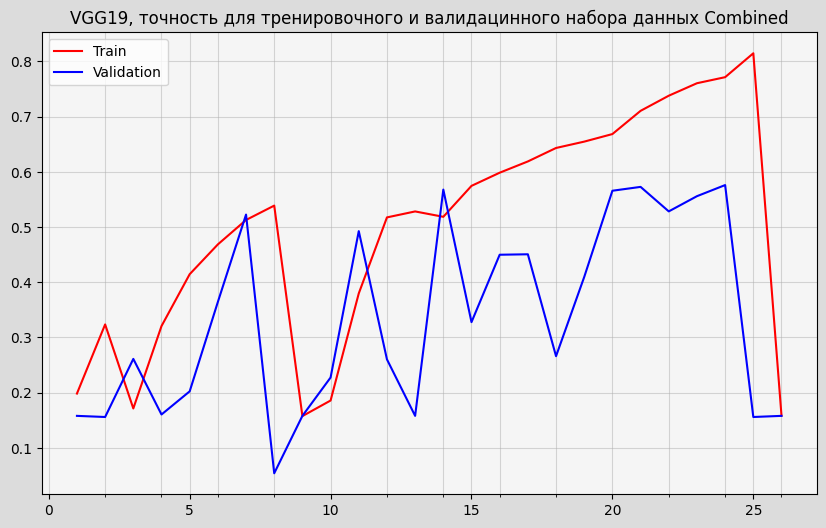

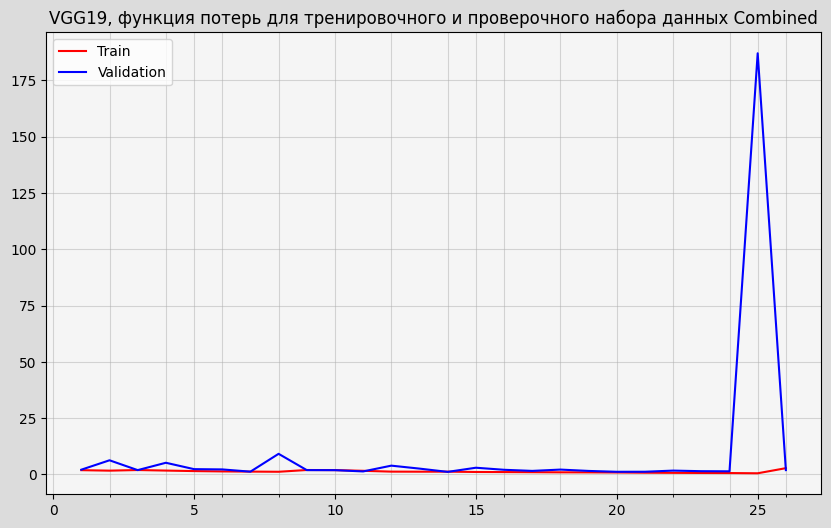

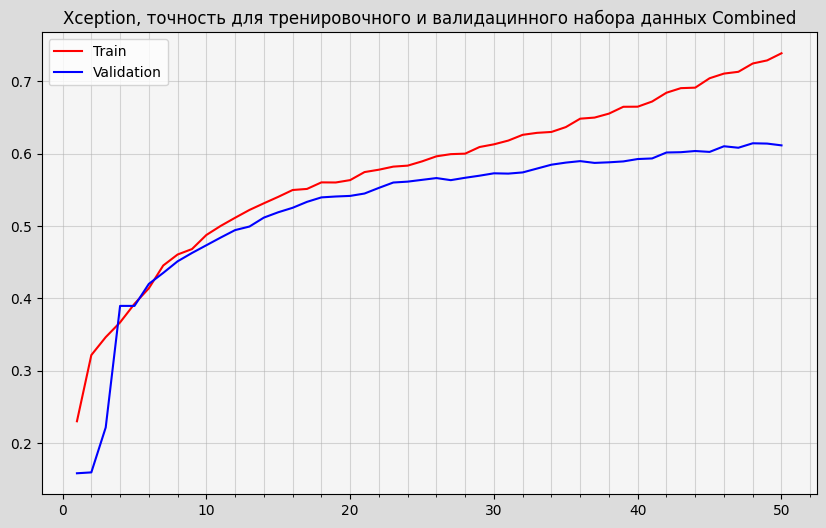

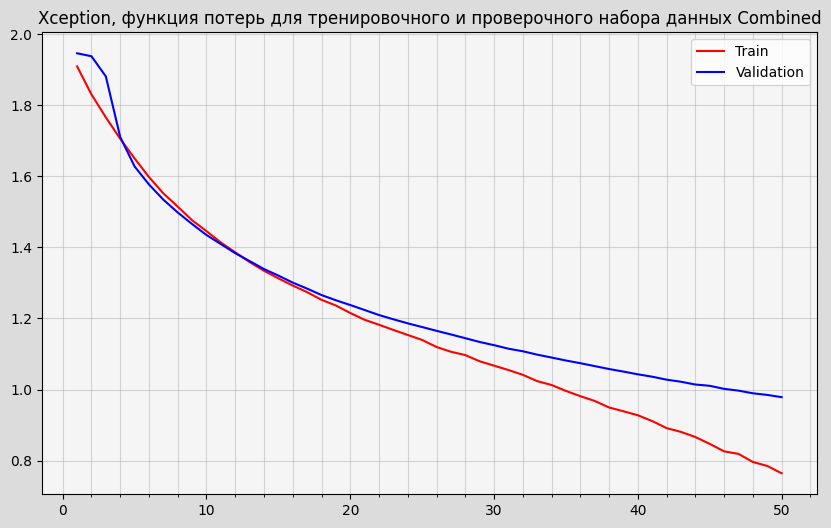

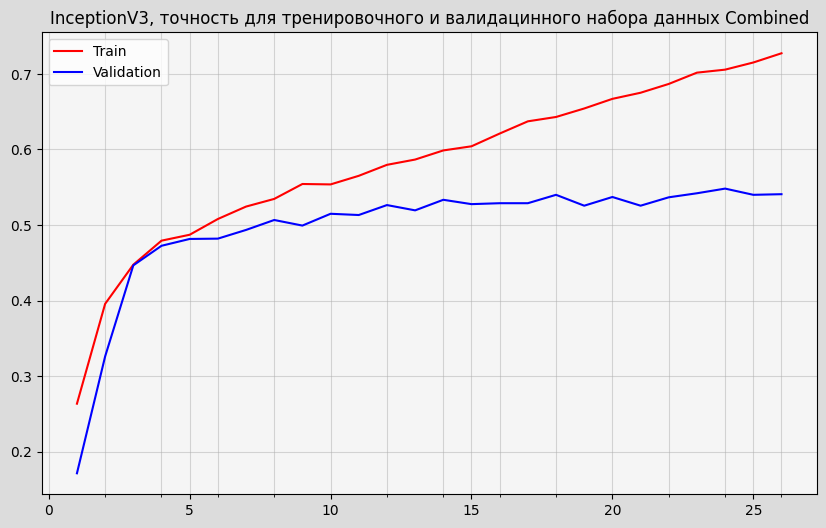

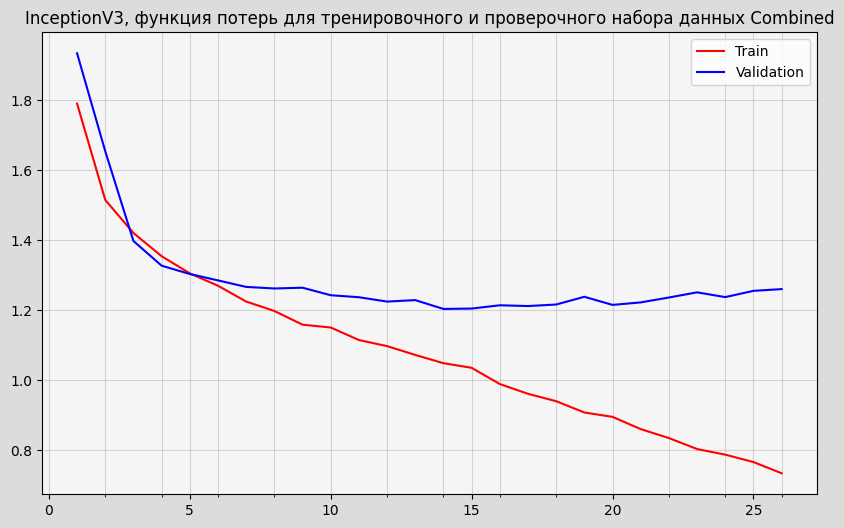

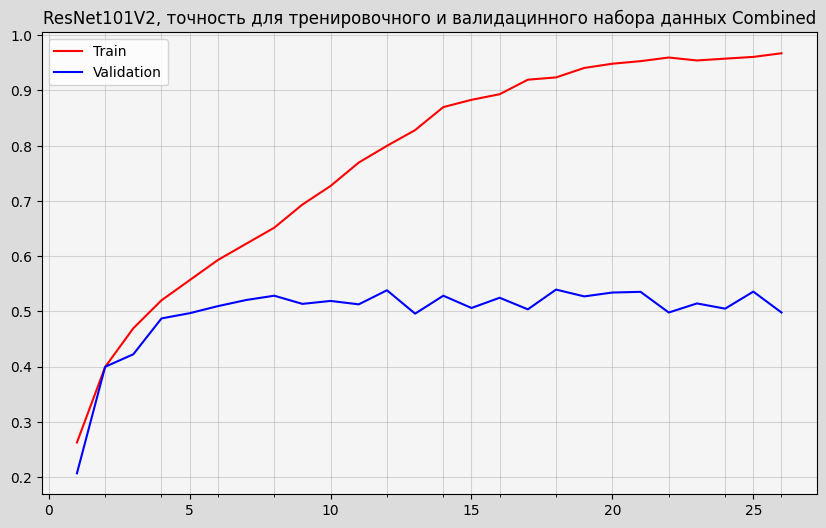

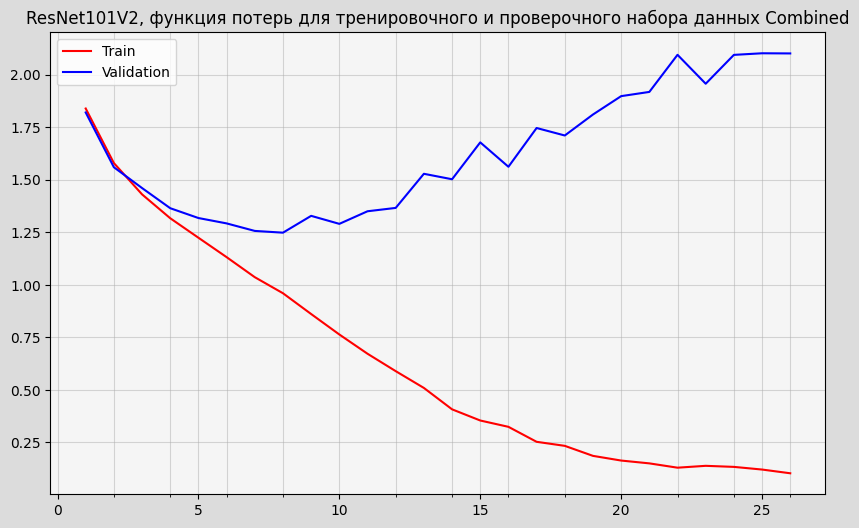

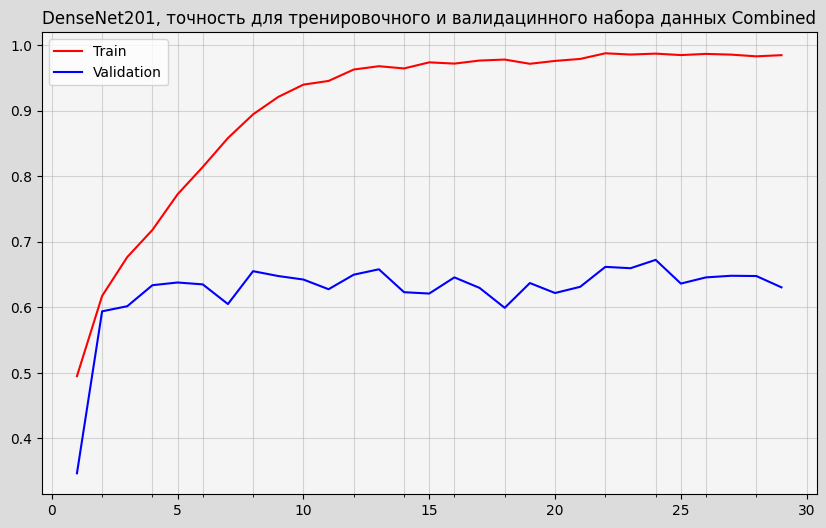

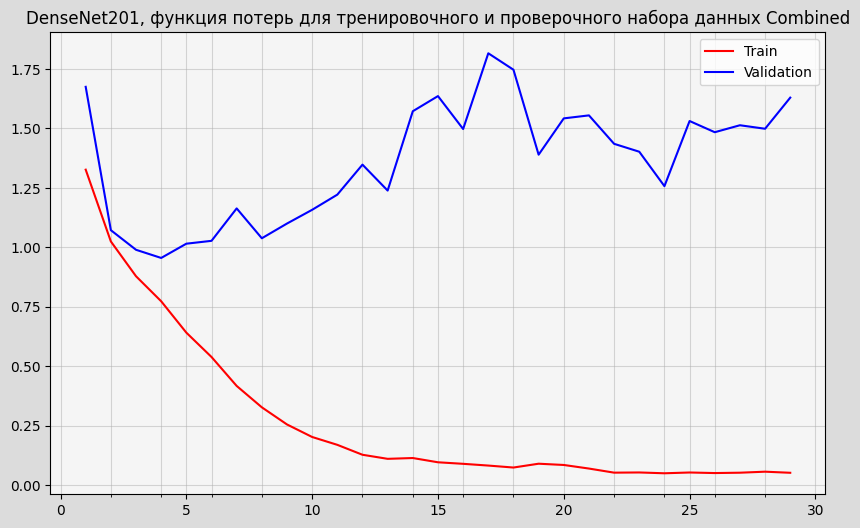

In [ ]:
# для визуализации обучения для combined датасета
with open(
    "drive/MyDrive/neuron_data/models_history/vgg19_combined_history.pkl", "rb"
) as file_pi:
    model_hist = pickle.load(file_pi)
do_plot_model_history(model_hist, vgg19_name, combined_name)
with open(
    "drive/MyDrive/neuron_data/models_history/xception_combined_history.pkl", "rb"
) as file_pi:
    model_hist = pickle.load(file_pi)
do_plot_model_history(model_hist, xception_name, combined_name)
with open(
    "drive/MyDrive/neuron_data/models_history/inception_combined_history.pkl", "rb"
) as file_pi:
    model_hist = pickle.load(file_pi)
do_plot_model_history(model_hist, inception_name, combined_name)
with open(
    "drive/MyDrive/neuron_data/models_history/resnet_combined_history.pkl", "rb"
) as file_pi:
    model_hist = pickle.load(file_pi)
do_plot_model_history(model_hist, resnet_name, combined_name)
with open(
    "drive/MyDrive/neuron_data/models_history/densenet_combined_history.pkl", "rb"
) as file_pi:
    model_hist = pickle.load(file_pi)
do_plot_model_history(model_hist, densenet_name, combined_name)

In [ ]:
# датафреймы для сохранения значений посчитанных метрик
columns = [vgg19_name, xception_name, resnet_name, inception_name, densenet_name]
# rows = [tess_name, ravdess_name, crema_name, savee_name, combined_name]
rows = [tess_name, ravdess_name, savee_name, combined_name]
f1_df, precision_df, recall_df, accuracy_df = None, None, None, None
# f1
if os.path.exists(
    "drive/MyDrive/neuron_data/calculated_metrics/f1.csv"
) and os.path.isdir("drive/MyDrive/neuron_data/calculated_metrics/f1.csv"):
    f1_df = pd.read_csv("drive/MyDrive/neuron_data/calculated_metrics/f1.csv")
else:
    f1_df = pd.DataFrame(columns=columns, index=rows)
# precision
if os.path.exists(
    "drive/MyDrive/neuron_data/calculated_metrics/precision.csv"
) and os.path.isdir("drive/MyDrive/neuron_data/calculated_metrics/precision.csv"):
    precision_df = pd.read_csv(
        "drive/MyDrive/neuron_data/calculated_metrics/precision.csv"
    )
else:
    precision_df = pd.DataFrame(columns=columns, index=rows)
# recall
if os.path.exists(
    "drive/MyDrive/neuron_data/calculated_metrics/recall.csv"
) and os.path.isdir("drive/MyDrive/neuron_data/calculated_metrics/recall.csv"):
    recall_df = pd.read_csv("drive/MyDrive/neuron_data/calculated_metrics/recall.csv")
else:
    recall_df = pd.DataFrame(columns=columns, index=rows)
# accuracy
if os.path.exists(
    "drive/MyDrive/neuron_data/calculated_metrics/accuracy.csv"
) and os.path.isdir("drive/MyDrive/neuron_data/calculated_metrics/accuracy.csv"):
    accuracy_df = pd.read_csv(
        "drive/MyDrive/neuron_data/calculated_metrics/accuracy.csv"
    )
else:
    accuracy_df = pd.DataFrame(columns=columns, index=rows)

In [ ]:
def do_prediction(t_model, model_name, dt_name, X_for_test):
    # Считаем прогноз на универсальном тестовом наборе
    y_test_pred = t_model.predict(X_for_test)
    y_test_pred_classes = np.argmax(y_test_pred, axis=-1)
    # Считаем метрики
    precision = precision_score(
        np.argmax(y_test_combined, axis=-1), y_test_pred_classes, average="weighted"
    )
    recall = recall_score(
        np.argmax(y_test_combined, axis=-1), y_test_pred_classes, average="weighted"
    )
    f1 = f1_score(
        np.argmax(y_test_combined, axis=-1), y_test_pred_classes, average="weighted"
    )
    accuracy_pred = accuracy_score(
        np.argmax(y_test_combined, axis=-1), y_test_pred_classes
    )
    # Выводим
    print(f"=== Посчитанные метрики для {model_name} для датасета {dt_name} ===")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("Accuracy:", accuracy_pred)
    # сохраняем посчитанные метрики в датафреймы
    precision_df.at[dt_name, model_name] = precision
    recall_df.at[dt_name, model_name] = recall
    f1_df.at[dt_name, model_name] = f1
    accuracy_df.at[dt_name, model_name] = accuracy_pred
    # сохраняем изменения
    precision_df.to_csv(
        "drive/MyDrive/neuron_data/calculated_metrics/precision.csv", index=False
    )
    recall_df.to_csv(
        "drive/MyDrive/neuron_data/calculated_metrics/recall.csv", index=False
    )
    f1_df.to_csv("drive/MyDrive/neuron_data/calculated_metrics/f1.csv", index=False)
    accuracy_df.to_csv(
        "drive/MyDrive/neuron_data/calculated_metrics/accuracy.csv", index=False
    )
    return y_test_pred_classes

In [ ]:
def do_plot_confusion_matrix(
    true_labels, predicted_labels, classes, model_name, dataset_name
):
    # Получаем данные для построения матрицы ошибок
    cm = confusion_matrix(true_labels, predicted_labels)
    # Нормализуем значения матрицы ошибок
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    # Строим матрицу ошибок
    plt.figure(figsize=(8, 6))
    plt.title(f"Матрица ошибок {model_name} для датасета {dataset_name}")
    ax = sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap="Blues", xticklabels=classes)
    ax.set_yticklabels(classes, rotation=0)
    plt.xlabel("Предсказанный класс", fontsize=12)
    plt.ylabel("Истинный класс", fontsize=12)
    plt.show()

77/77 [==============================] - 14s 50ms/step
=== Посчитанные метрики для VGG19 для датасета TESS ===
Precision: 0.5003796068180105
Recall: 0.39005343197698317
F1-Score: 0.3923370569328195
Accuracy: 0.39005343197698317
77/77 [==============================] - 4s 46ms/step
=== Посчитанные метрики для VGG19 для датасета RAVDESS ===
Precision: 0.2838091642822649
Recall: 0.22071516646115907
F1-Score: 0.20918187043369246
Accuracy: 0.22071516646115907
77/77 [==============================] - 4s 46ms/step
=== Посчитанные метрики для VGG19 для датасета SAVEE ===
Precision: 0.19984783822614882
Recall: 0.20016440608302508
F1-Score: 0.1707121167280411
Accuracy: 0.20016440608302508
77/77 [==============================] - 4s 46ms/step
=== Посчитанные метрики для VGG19 для датасета Combined ===
Precision: 0.7310232268488468
Recall: 0.7011919441019318
F1-Score: 0.6995273545601912
Accuracy: 0.7011919441019318


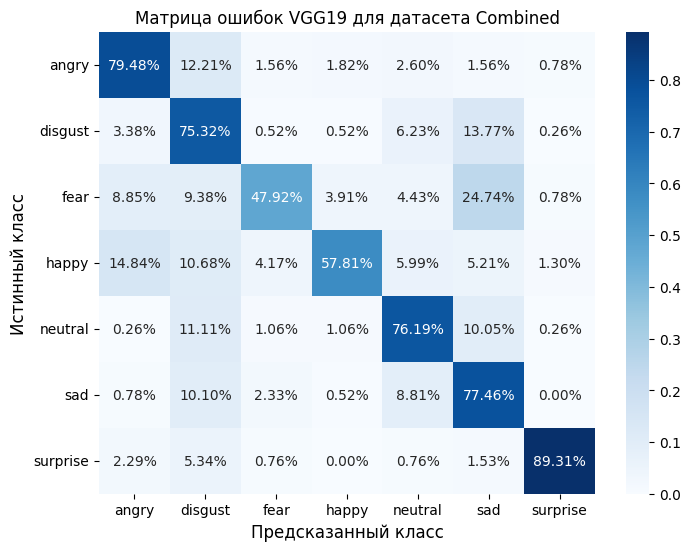

77/77 [==============================] - 5s 40ms/step
=== Посчитанные метрики для Xception для датасета TESS ===
Precision: 0.697704647611044
Recall: 0.3711467324290999
F1-Score: 0.3756836516115456
Accuracy: 0.3711467324290999
77/77 [==============================] - 3s 36ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


=== Посчитанные метрики для Xception для датасета RAVDESS ===
Precision: 0.2682776776005601
Recall: 0.22359227291409783
F1-Score: 0.14388901338121576
Accuracy: 0.22359227291409783
77/77 [==============================] - 3s 37ms/step
=== Посчитанные метрики для Xception для датасета SAVEE ===
Precision: 0.002899067808048972
Recall: 0.05384299219071106
F1-Score: 0.005501897017927573
Accuracy: 0.05384299219071106


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


77/77 [==============================] - 3s 36ms/step
=== Посчитанные метрики для Xception для датасета Combined ===
Precision: 0.7122212782081301
Recall: 0.7098232634607481
F1-Score: 0.7098360720366219
Accuracy: 0.7098232634607481


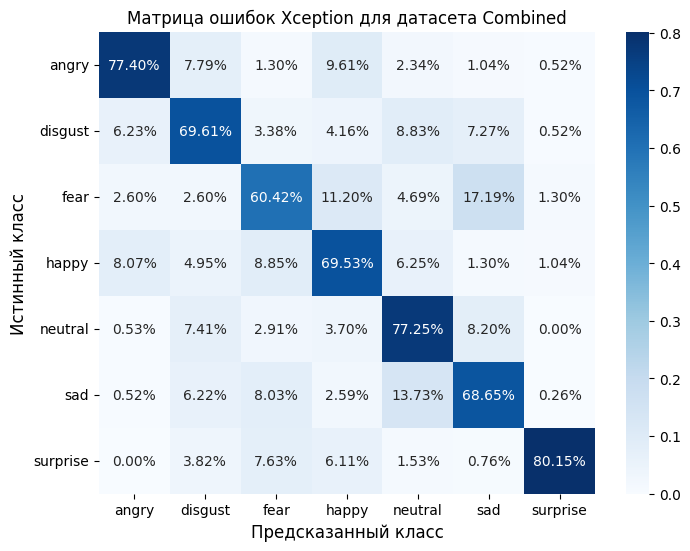

77/77 [==============================] - 5s 28ms/step
=== Посчитанные метрики для InceptionV3 для датасета TESS ===
Precision: 0.5746317529482959
Recall: 0.35388409371146734
F1-Score: 0.3631176450811469
Accuracy: 0.35388409371146734
77/77 [==============================] - 2s 23ms/step
=== Посчитанные метрики для InceptionV3 для датасета RAVDESS ===
Precision: 0.29449640120735593
Recall: 0.2642827784628031
F1-Score: 0.2578440573634761
Accuracy: 0.2642827784628031
77/77 [==============================] - 2s 31ms/step
=== Посчитанные метрики для InceptionV3 для датасета SAVEE ===
Precision: 0.02415775274265156
Recall: 0.15536374845869297
F1-Score: 0.04181381054993659
Accuracy: 0.15536374845869297


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


77/77 [==============================] - 2s 31ms/step
=== Посчитанные метрики для InceptionV3 для датасета Combined ===
Precision: 0.685474527465742
Recall: 0.6835182901767365
F1-Score: 0.683567292644318
Accuracy: 0.6835182901767365


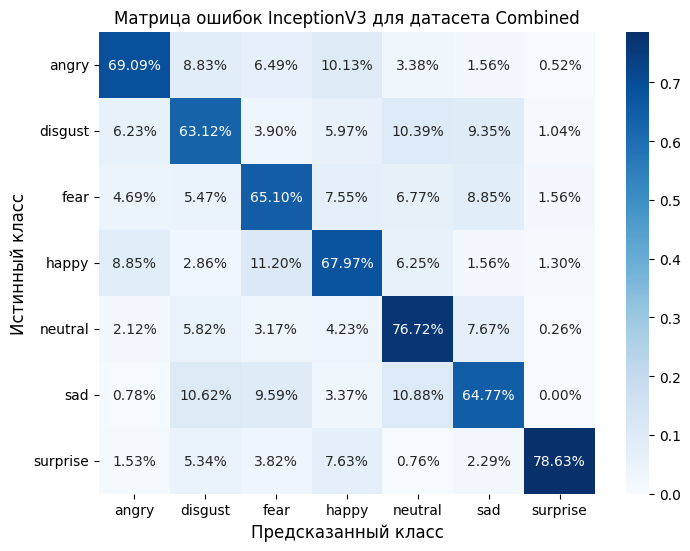

77/77 [==============================] - 7s 58ms/step
=== Посчитанные метрики для ResNet101V2 для датасета TESS ===
Precision: 0.6629197279749469
Recall: 0.35922729140978216
F1-Score: 0.35934887671246823
Accuracy: 0.35922729140978216
77/77 [==============================] - 4s 51ms/step
=== Посчитанные метрики для ResNet101V2 для датасета RAVDESS ===
Precision: 0.4021875411575367
Recall: 0.30579531442663377
F1-Score: 0.27431925618699243
Accuracy: 0.30579531442663377
77/77 [==============================] - 4s 56ms/step
=== Посчитанные метрики для ResNet101V2 для датасета SAVEE ===
Precision: 0.002887619218148695
Recall: 0.053431976983148374
F1-Score: 0.005479130320776859
Accuracy: 0.053431976983148374


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


77/77 [==============================] - 4s 52ms/step
=== Посчитанные метрики для ResNet101V2 для датасета Combined ===
Precision: 0.8295240750301798
Recall: 0.8212083847102343
F1-Score: 0.8220104095522528
Accuracy: 0.8212083847102343


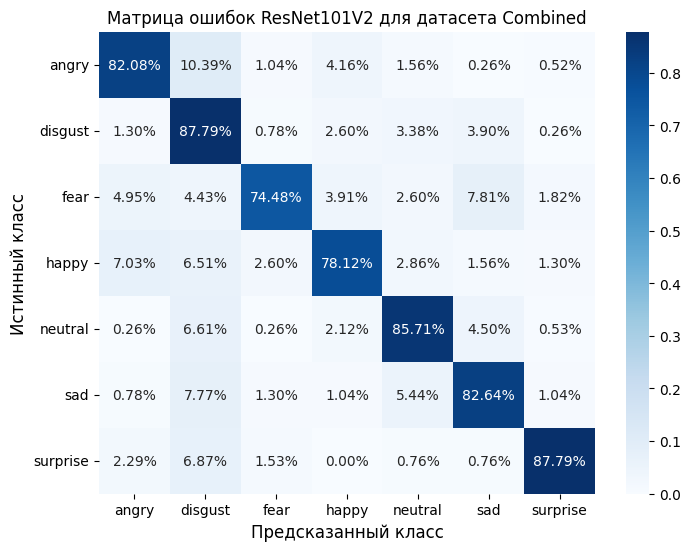

77/77 [==============================] - 10s 60ms/step
=== Посчитанные метрики для DenseNet201 для датасета TESS ===
Precision: 0.667205782568399
Recall: 0.3637484586929716
F1-Score: 0.35790287325897047
Accuracy: 0.3637484586929716
77/77 [==============================] - 4s 48ms/step
=== Посчитанные метрики для DenseNet201 для датасета RAVDESS ===
Precision: 0.3726777431114828
Recall: 0.2651048088779285
F1-Score: 0.24879653306972338
Accuracy: 0.2651048088779285
77/77 [==============================] - 4s 47ms/step
=== Посчитанные метрики для DenseNet201 для датасета SAVEE ===
Precision: 0.2101968597550318
Recall: 0.14508836826962598
F1-Score: 0.14307694974833263
Accuracy: 0.14508836826962598
77/77 [==============================] - 4s 46ms/step
=== Посчитанные метрики для DenseNet201 для датасета Combined ===
Precision: 0.880160240694572
Recall: 0.8775174681463214
F1-Score: 0.8777058713575542
Accuracy: 0.8775174681463214


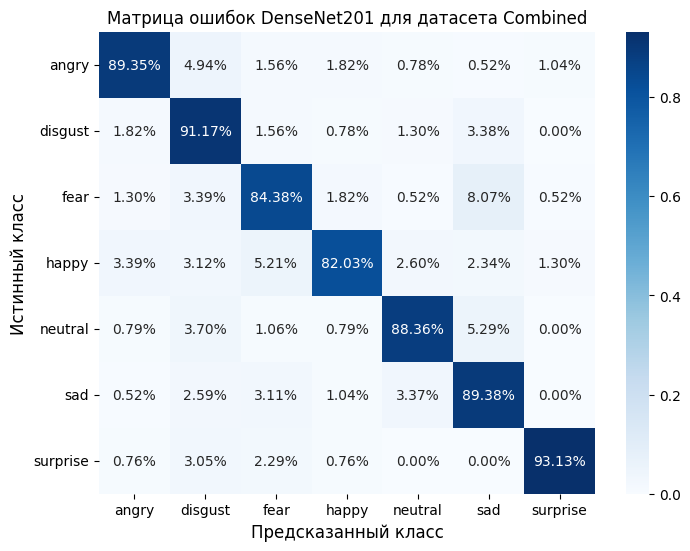

In [ ]:
# Предсказанные метки
predicted_labels = None

do_predict_vgg19 = False
do_predict_xception = False
do_predict_inception = False
do_predict_resnet = False
do_predict_densenet = False

# Если нужно - пересчитываем, если нет - загружаем сохранённые
# vgg19
if do_predict_vgg19 == True:
    # собираем модель
    model = get_vgg19(input_data_shape, num_classes)
    # загружаем веса, делаем прогноз и затем сохраняем его
    # tess
    model.load_weights("drive/MyDrive/neuron_data/models_history/vgg19_tess_weights.h5")
    predicted_labels = do_prediction(model, vgg19_name, tess_name, X_test_combined)
    np.save(
        "drive/MyDrive/neuron_data/prediction_for_matrix/predicted_vgg19_tess.npy",
        predicted_labels,
    )
    # ravdess
    model.load_weights(
        "drive/MyDrive/neuron_data/models_history/vgg19_ravdess_weights.h5"
    )
    predicted_labels = do_prediction(model, vgg19_name, ravdess_name, X_test_combined)
    np.save(
        "drive/MyDrive/neuron_data/prediction_for_matrix/predicted_vgg19_ravdess.npy",
        predicted_labels,
    )
    # savee
    model.load_weights(
        "drive/MyDrive/neuron_data/models_history/vgg19_savee_weights.h5"
    )
    predicted_labels = do_prediction(model, vgg19_name, savee_name, X_test_combined)
    np.save(
        "drive/MyDrive/neuron_data/prediction_for_matrix/predicted_vgg19_savee.npy",
        predicted_labels,
    )
    # combined
    model.load_weights(
        "drive/MyDrive/neuron_data/models_history/vgg19_combined_weights.h5"
    )
    predicted_labels = do_prediction(model, vgg19_name, combined_name, X_test_combined)
    np.save(
        "drive/MyDrive/neuron_data/prediction_for_matrix/predicted_vgg19_combined.npy",
        predicted_labels,
    )
    # crema
    # model = get_vgg19(input_data_shape, num_classes_crema)
    # model.load_weights("drive/MyDrive/neuron_data/models_history/vgg19_crema_weights.h5")
    # predicted_labels = do_prediction(model, vgg19_name, crema_name, X_test_combined)
    # np.save('drive/MyDrive/neuron_data/prediction_for_matrix/predicted_vgg19_crema.npy', predicted_labels)

else:
    predicted_labels = np.load(
        "drive/MyDrive/neuron_data/prediction_for_matrix/predicted_vgg19_combined.npy"
    )
do_plot_confusion_matrix(
    true_labels, predicted_labels, classes_emotion, vgg19_name, combined_name
)

# xception
if do_predict_xception == True:
    # собираем модель
    model = get_xception(input_data_shape, num_classes)
    # загружаем веса, делаем прогноз и затем сохраняем его
    # tess
    model.load_weights(
        "drive/MyDrive/neuron_data/models_history/xception_tess_weights.h5"
    )
    predicted_labels = do_prediction(model, xception_name, tess_name, X_test_combined)
    np.save(
        "drive/MyDrive/neuron_data/prediction_for_matrix/predicted_xception_tess.npy",
        predicted_labels,
    )
    # ravdess
    model.load_weights(
        "drive/MyDrive/neuron_data/models_history/xception_ravdess_weights.h5"
    )
    predicted_labels = do_prediction(
        model, xception_name, ravdess_name, X_test_combined
    )
    np.save(
        "drive/MyDrive/neuron_data/prediction_for_matrix/predicted_xception_ravdess.npy",
        predicted_labels,
    )
    # savee
    model.load_weights(
        "drive/MyDrive/neuron_data/models_history/xception_savee_weights.h5"
    )
    predicted_labels = do_prediction(model, xception_name, savee_name, X_test_combined)
    np.save(
        "drive/MyDrive/neuron_data/prediction_for_matrix/predicted_xception_savee.npy",
        predicted_labels,
    )
    # combined
    model.load_weights(
        "drive/MyDrive/neuron_data/models_history/xception_combined_weights.h5"
    )
    predicted_labels = do_prediction(
        model, xception_name, combined_name, X_test_combined
    )
    np.save(
        "drive/MyDrive/neuron_data/prediction_for_matrix/predicted_xception_combined.npy",
        predicted_labels,
    )
    # crema
    # model = get_xception(input_data_shape, num_classes_crema)
    # model.load_weights("drive/MyDrive/neuron_data/models_history/xception_crema_weights.h5")
    # predicted_labels = do_prediction(model, xception_name, crema_name, X_test_combined)
    # np.save('drive/MyDrive/neuron_data/prediction_for_matrix/predicted_xception_crema.npy', predicted_labels)
else:
    predicted_labels = np.load(
        "drive/MyDrive/neuron_data/prediction_for_matrix/predicted_xception_combined.npy"
    )
do_plot_confusion_matrix(
    true_labels, predicted_labels, classes_emotion, xception_name, combined_name
)

# inception
if do_predict_inception == True:
    # собираем модель
    model = get_inception(input_data_shape, num_classes)
    # загружаем веса, делаем прогноз и затем сохраняем его
    # tess
    model.load_weights(
        "drive/MyDrive/neuron_data/models_history/inception_tess_weights.h5"
    )
    predicted_labels = do_prediction(model, inception_name, tess_name, X_test_combined)
    np.save(
        "drive/MyDrive/neuron_data/prediction_for_matrix/predicted_inception_tess.npy",
        predicted_labels,
    )
    # ravdess
    model.load_weights(
        "drive/MyDrive/neuron_data/models_history/inception_ravdess_weights.h5"
    )
    predicted_labels = do_prediction(
        model, inception_name, ravdess_name, X_test_combined
    )
    np.save(
        "drive/MyDrive/neuron_data/prediction_for_matrix/predicted_inception_ravdess.npy",
        predicted_labels,
    )
    # savee
    model.load_weights(
        "drive/MyDrive/neuron_data/models_history/inception_savee_weights.h5"
    )
    predicted_labels = do_prediction(model, inception_name, savee_name, X_test_combined)
    np.save(
        "drive/MyDrive/neuron_data/prediction_for_matrix/predicted_inception_savee.npy",
        predicted_labels,
    )
    # combined
    model.load_weights(
        "drive/MyDrive/neuron_data/models_history/inception_combined_weights.h5"
    )
    predicted_labels = do_prediction(
        model, inception_name, combined_name, X_test_combined
    )
    np.save(
        "drive/MyDrive/neuron_data/prediction_for_matrix/predicted_inception_combined.npy",
        predicted_labels,
    )
    # crema
    # model = get_inception(input_data_shape, num_classes_crema)
    # model.load_weights("drive/MyDrive/neuron_data/models_history/inception_crema_weights.h5")
    # predicted_labels = do_prediction(model, inception_name, crema_name, X_test_combined)
    # np.save('drive/MyDrive/neuron_data/prediction_for_matrix/predicted_inception_crema.npy', predicted_labels)
else:
    predicted_labels = np.load(
        "drive/MyDrive/neuron_data/prediction_for_matrix/predicted_inception_combined.npy"
    )
do_plot_confusion_matrix(
    true_labels, predicted_labels, classes_emotion, inception_name, combined_name
)

# resnet
if do_predict_resnet == True:
    # собираем модель
    model = get_resnet(input_data_shape, num_classes)
    # загружаем веса, делаем прогноз и затем сохраняем его
    # tess
    model.load_weights(
        "drive/MyDrive/neuron_data/models_history/resnet_tess_weights.h5"
    )
    predicted_labels = do_prediction(model, resnet_name, tess_name, X_test_combined)
    np.save(
        "drive/MyDrive/neuron_data/prediction_for_matrix/predicted_resnet_tess.npy",
        predicted_labels,
    )
    # ravdess
    model.load_weights(
        "drive/MyDrive/neuron_data/models_history/resnet_ravdess_weights.h5"
    )
    predicted_labels = do_prediction(model, resnet_name, ravdess_name, X_test_combined)
    np.save(
        "drive/MyDrive/neuron_data/prediction_for_matrix/predicted_resnet_ravdess.npy",
        predicted_labels,
    )
    # savee
    model.load_weights(
        "drive/MyDrive/neuron_data/models_history/resnet_savee_weights.h5"
    )
    predicted_labels = do_prediction(model, resnet_name, savee_name, X_test_combined)
    np.save(
        "drive/MyDrive/neuron_data/prediction_for_matrix/predicted_resnet_savee.npy",
        predicted_labels,
    )
    # combined
    model.load_weights(
        "drive/MyDrive/neuron_data/models_history/resnet_combined_weights.h5"
    )
    predicted_labels = do_prediction(model, resnet_name, combined_name, X_test_combined)
    np.save(
        "drive/MyDrive/neuron_data/prediction_for_matrix/predicted_resnet_combined.npy",
        predicted_labels,
    )
    # crema
    # model = get_resnet(input_data_shape, num_classes_crema)
    # model.load_weights("drive/MyDrive/neuron_data/models_history/resnet_crema_weights.h5")
    # predicted_labels = do_prediction(model, resnet_name, crema_name, X_test_combined)
    # np.save('drive/MyDrive/neuron_data/prediction_for_matrix/predicted_resnet_crema.npy', predicted_labels)
else:
    predicted_labels = np.load(
        "drive/MyDrive/neuron_data/prediction_for_matrix/predicted_resnet_combined.npy"
    )
do_plot_confusion_matrix(
    true_labels, predicted_labels, classes_emotion, resnet_name, combined_name
)

# densenet
if do_predict_densenet == True:
    # собираем модель
    model = get_densenet(input_data_shape, num_classes)
    # загружаем веса, делаем прогноз и затем сохраняем его
    # tess
    model.load_weights(
        "drive/MyDrive/neuron_data/models_history/densenet_tess_weights.h5"
    )
    predicted_labels = do_prediction(model, densenet_name, tess_name, X_test_combined)
    np.save(
        "drive/MyDrive/neuron_data/prediction_for_matrix/predicted_densenet_tess.npy",
        predicted_labels,
    )
    # ravdess
    model.load_weights(
        "drive/MyDrive/neuron_data/models_history/densenet_ravdess_weights.h5"
    )
    predicted_labels = do_prediction(
        model, densenet_name, ravdess_name, X_test_combined
    )
    np.save(
        "drive/MyDrive/neuron_data/prediction_for_matrix/predicted_densenet_ravdess.npy",
        predicted_labels,
    )
    # savee
    model.load_weights(
        "drive/MyDrive/neuron_data/models_history/densenet_savee_weights.h5"
    )
    predicted_labels = do_prediction(model, densenet_name, savee_name, X_test_combined)
    np.save(
        "drive/MyDrive/neuron_data/prediction_for_matrix/predicted_densenet_savee.npy",
        predicted_labels,
    )
    # combined
    model.load_weights(
        "drive/MyDrive/neuron_data/models_history/densenet_combined_weights.h5"
    )
    predicted_labels = do_prediction(
        model, densenet_name, combined_name, X_test_combined
    )
    np.save(
        "drive/MyDrive/neuron_data/prediction_for_matrix/predicted_densenet_combined.npy",
        predicted_labels,
    )
    # crema
    # model = get_densenet(input_data_shape, num_classes_crema)
    # model.load_weights("drive/MyDrive/neuron_data/models_history/densenet_crema_weights.h5")
    # predicted_labels = do_prediction(model, densenet_name, crema_name, X_test_combined)
    # np.save('drive/MyDrive/neuron_data/prediction_for_matrix/predicted_densenet_crema.npy', predicted_labels)
else:
    predicted_labels = np.load(
        "drive/MyDrive/neuron_data/prediction_for_matrix/predicted_densenet_combined.npy"
    )
do_plot_confusion_matrix(
    true_labels, predicted_labels, classes_emotion, densenet_name, combined_name
)

In [ ]:
# Смотрим точность и функцию потерь
see_best_loss_acc = False

if see_best_loss_acc == True:
    # vgg19 combined
    model = get_vgg19(input_data_shape, num_classes)
    model.load_weights(
        "drive/MyDrive/neuron_data/models_history/vgg19_combined_weights.h5"
    )
    # Оцениваем модель на валидационной выборки чтобы получить валидационную функцию ошибки и точность
    loss_to_show, acc_to_show = model.evaluate(X_val_combined, y_val_combined)
    print(f" === Характеристики модели VGG19 === ")
    print(f"Значение функции ошибки модели на валидационном наборе: {loss_to_show}")
    print(f"Точность модели на валидационном наборе: {acc_to_show}")

    # xception combined
    model = get_xception(input_data_shape, num_classes)
    model.load_weights(
        "drive/MyDrive/neuron_data/models_history/xception_combined_weights.h5"
    )
    # Оцениваем модель на валидационной выборки чтобы получить валидационную функцию ошибки и точность
    loss_to_show, acc_to_show = model.evaluate(X_val_combined, y_val_combined)
    print(" === Характеристики модели Xception === ")
    print(f"Значение функции ошибки модели на валидационном наборе: {loss_to_show}")
    print(f"Точность модели на валидационном наборе: {acc_to_show}")

    # inception combined
    model = get_inception(input_data_shape, num_classes)
    model.load_weights(
        "drive/MyDrive/neuron_data/models_history/inception_combined_weights.h5"
    )
    # Оцениваем модель на валидационной выборки чтобы получить валидационную функцию ошибки и точность
    loss_to_show, acc_to_show = model.evaluate(X_val_combined, y_val_combined)
    print(" === Характеристики модели InceptionV3 === ")
    print(f"Значение функции ошибки модели на валидационном наборе: {loss_to_show}")
    print(f"Точность модели на валидационном наборе: {acc_to_show}")

    # resnet combined
    model = get_resnet(input_data_shape, num_classes)
    model.load_weights(
        "drive/MyDrive/neuron_data/models_history/resnet_combined_weights.h5"
    )
    # Оцениваем модель на валидационной выборки чтобы получить валидационную функцию ошибки и точность
    loss_to_show, acc_to_show = model.evaluate(X_val_combined, y_val_combined)
    print(" === Характеристики модели ResNet101V2 === ")
    print(f"Значение функции ошибки модели на валидационном наборе: {loss_to_show}")
    print(f"Точность модели на валидационном наборе: {acc_to_show}")

    # densenet combined
    model = get_densenet(input_data_shape, num_classes)
    model.load_weights(
        "drive/MyDrive/neuron_data/models_history/densenet_combined_weights.h5"
    )
    # Оцениваем модель на валидационной выборки чтобы получить валидационную функцию ошибки и точность
    loss_to_show, acc_to_show = model.evaluate(X_val_combined, y_val_combined)
    print(" === Характеристики модели DenseNet201 === ")
    print(f"Значение функции ошибки модели на валидационном наборе: {loss_to_show}")
    print(f"Точность модели на валидационном наборе: {acc_to_show}")

76/76 [==============================] - 5s 58ms/step - loss: 0.8151 - accuracy: 0.7101
 === Характеристики модели VGG19 === 
Значение функции ошибки модели на валидационном наборе: 0.8150978684425354
Точность модели на валидационном наборе: 0.7101151347160339
76/76 [==============================] - 5s 41ms/step - loss: 0.7951 - accuracy: 0.7126
 === Характеристики модели Xception === 
Значение функции ошибки модели на валидационном наборе: 0.7950883507728577
Точность модели на валидационном наборе: 0.7125822305679321
76/76 [==============================] - 4s 24ms/step - loss: 0.8655 - accuracy: 0.6735
 === Характеристики модели InceptionV3 === 
Значение функции ошибки модели на валидационном наборе: 0.8654573559761047
Точность модели на валидационном наборе: 0.6735197305679321
76/76 [==============================] - 9s 57ms/step - loss: 0.8267 - accuracy: 0.8067
 === Характеристики модели ResNet101V2 === 
Значение функции ошибки модели на валидационном наборе: 0.8266830444335938
Т

In [ ]:
print(f1_df)

             VGG19  Xception ResNet101V2 InceptionV3 DenseNet201
TESS      0.392337  0.375684    0.359349    0.363118    0.357903
RAVDESS   0.209182  0.143889    0.274319    0.257844    0.248797
SAVEE     0.170712  0.005502    0.005479    0.041814    0.143077
Combined  0.699527  0.709836     0.82201    0.683567    0.877706


In [ ]:
print(precision_df)

             VGG19  Xception ResNet101V2 InceptionV3 DenseNet201
TESS       0.50038  0.697705     0.66292    0.574632    0.667206
RAVDESS   0.283809  0.268278    0.402188    0.294496    0.372678
SAVEE     0.199848  0.002899    0.002888    0.024158    0.210197
Combined  0.731023  0.712221    0.829524    0.685475     0.88016


In [ ]:
print(recall_df)

             VGG19  Xception ResNet101V2 InceptionV3 DenseNet201
TESS      0.390053  0.371147    0.359227    0.353884    0.363748
RAVDESS   0.220715  0.223592    0.305795    0.264283    0.265105
SAVEE     0.200164  0.053843    0.053432    0.155364    0.145088
Combined  0.701192  0.709823    0.821208    0.683518    0.877517


In [ ]:
print(accuracy_df)

             VGG19  Xception ResNet101V2 InceptionV3 DenseNet201
TESS      0.390053  0.371147    0.359227    0.353884    0.363748
RAVDESS   0.220715  0.223592    0.305795    0.264283    0.265105
SAVEE     0.200164  0.053843    0.053432    0.155364    0.145088
Combined  0.701192  0.709823    0.821208    0.683518    0.877517
